In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms

import numpy as np
import matplotlib.pyplot as plt

data_loc = './data/mnist/mnist.pkl'
data = np.load(data_loc)

## Helper Functions

The following cells contain functions used throughout the course of the question, they include model class creation, Glorot Initialization, Standardization of inputs and a function for creating data loaders for use during Pytorch training

In [5]:
mnist_train_data = data[0][0]
mnist_train_labels = data[0][1]

mnist_train_tensor = torch.utils.data.TensorDataset(torch.Tensor(mnist_train_data),torch.IntTensor(mnist_train_labels))

mnist_val_data = data[1][0]
mnist_val_labels = data[1][1]

mnist_val_tensor = torch.utils.data.TensorDataset(torch.Tensor(mnist_val_data),torch.IntTensor(mnist_val_labels))


mnist_test_data = data[2][0]
mnist_test_labels = data[2][1]

mnist_test_tensor = torch.utils.data.TensorDataset(torch.Tensor(mnist_test_data),torch.IntTensor(mnist_test_labels))


mnist_train = torch.utils.data.DataLoader(mnist_train_tensor, batch_size=64, shuffle=True, num_workers=2)
mnist_val = torch.utils.data.DataLoader(mnist_val_tensor, batch_size=64, shuffle=True, num_workers=2)
mnist_test = torch.utils.data.DataLoader(mnist_test_tensor, batch_size=64, shuffle=True, num_workers=2)


In [6]:
class MLP_MNIST(nn.Module):
    
    def __init__(self,dims,outsize,dropout=[0.0,0.0]):
        super(MLP_MNIST,self).__init__()
        self.fc1 = nn.Linear(dims[0],dims[1])
        self.dropout1 = nn.Dropout(p=dropout[0])
        self.fc2 = nn.Linear(dims[1],dims[2])
        self.dropout2 = nn.Dropout(p=dropout[1])
        self.fc3 = nn.Linear(dims[2],outsize)
        
        self.insize = dims[0]
        
    def forward(self,x):
        a1 = self.fc1(x)
        d1 = self.dropout1(a1)
        h1 = nn.functional.relu(d1)
        
        a2 = self.fc2(h1)
        d2 = self.dropout2(a2)
        h2 = nn.functional.relu(d2)
        
        logits = self.fc3(h2)
        
        return logits
    
    def prediction(self,logits):
        
        values, indices = torch.max(logits.data,1)
        
        return values, indices


In [7]:
def init_train(model,trainloader,lr,batch_size):
    print model
    loss_crit = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=lr)
    NUMEPOCHS=10
    epoch_loss= [0]*NUMEPOCHS
    for epoch in range(NUMEPOCHS):
        losses = []
        for batch_index, (inputs, targets) in enumerate(trainloader):
            x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

            logits = model.forward(x)
    
            loss = loss_crit(logits,targets)
            loss.backward()
            optimizer.step()

            losses.append(loss.data[0])
        epoch_loss[epoch] = np.mean(losses)
        print('Epoch : %d Loss : %.3f ' % (epoch+1, np.mean(losses)))
    return epoch_loss

#Initializes using Glorot Initialization
def GlorotInitialize(model):
    params = list(model.parameters())

    for p in params:
        if len(p.size()) > 1:
            dl = np.sqrt(6.0/(p.size()[0]+p.size()[1]))
            nn.init.uniform(p,-dl,dl)
        else:
            nn.init.uniform(p,0,0)
            
    return model

## 1.A.1 Initialization Loss Curves

For each of the following tests the model architecture has 2 hidden layers one of size 500 and one of size 200. Additionally, each model has an input layer the size of the number of pixels in the samples , 784, and 10 output neurons, one for each class.

The non-linearity is a Rectified Linear Unit (ReLu), the output layer uses a log-softmax function and the loss uses standard cross entropy loss. The batch size for each test is 64.

Zero weight initialization
MLP_MNIST(
  (fc1): Linear(in_features=784, out_features=500)
  (dropout1): Dropout(p=0.0)
  (fc2): Linear(in_features=500, out_features=200)
  (dropout2): Dropout(p=0.0)
  (fc3): Linear(in_features=200, out_features=10)
)
Epoch : 1 Loss : 2.302 
Epoch : 2 Loss : 2.302 
Epoch : 3 Loss : 2.302 
Epoch : 4 Loss : 2.302 
Epoch : 5 Loss : 2.302 
Epoch : 6 Loss : 2.302 
Epoch : 7 Loss : 2.302 
Epoch : 8 Loss : 2.302 
Epoch : 9 Loss : 2.302 
Epoch : 10 Loss : 2.303 
Normal weight initialization mean of zero, variance of 1
MLP_MNIST(
  (fc1): Linear(in_features=784, out_features=500)
  (dropout1): Dropout(p=0.0)
  (fc2): Linear(in_features=500, out_features=200)
  (dropout2): Dropout(p=0.0)
  (fc3): Linear(in_features=200, out_features=10)
)
Epoch : 1 Loss : 34.032 
Epoch : 2 Loss : 2.309 
Epoch : 3 Loss : 2.569 
Epoch : 4 Loss : 2.314 
Epoch : 5 Loss : 2.313 
Epoch : 6 Loss : 2.316 
Epoch : 7 Loss : 2.316 
Epoch : 8 Loss : 2.322 
Epoch : 9 Loss : 2.325 
Epoch : 10 L

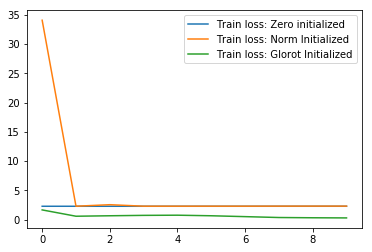

In [42]:
#Zero Weight Initialization
print "Zero weight initialization"
lr=1e-4
ZeroInitNet = MLP_MNIST([28*28,500,200],10)
params = list(ZeroInitNet.parameters())
for p in params:
    nn.init.uniform(p,0,0)
    
zero_losses = init_train(ZeroInitNet,mnist_train,lr,128)

print "Normal weight initialization mean of zero, variance of 1"
lr=1e-3
NormInitNet = MLP_MNIST([28*28,500,200],10)
params = list(NormInitNet.parameters())
for p in params:
    if len(p.size()) > 1:
        nn.init.normal(p,0,1)
    else:
        nn.init.uniform(p,0,0)
norm_losses = init_train(NormInitNet,mnist_train,lr,128)

print " Glorot Initialization"
lr=1e-5
GlorotInitNet = MLP_MNIST([28*28,500,200],10)
GlorotInit_Net = GlorotInitialize(GlorotInitNet)
glorot_losses = init_train(GlorotInit_Net,mnist_train,lr,128)

plt.plot(zero_losses,label='Train loss: Zero initialized ')
plt.plot(norm_losses,label='Train loss: Norm Initialized')
plt.plot(glorot_losses,label='Train loss: Glorot Initialized')
plt.legend()
plt.show()
    

## 1.A.2 Initialization Comments
First it should be noted that the loss remains unchanged when using 0 weight intialization.  This can be attributed to the fact that each neuron will output the same value during forward propagatio and receive the same gradient during back propagation. When considering back propagation, each neuron will follow the same gradient and change identically. Thus the network will not learn.

Second, when intializing values using a normal distribution, the intial loss is very high. This is because the weight values can be quite high and lead to very strong incorrect predictions. Furthermore,the intialization values will increase the variance of the outputs during forward propagation, and the variance of the gradiant during backwards propagation. While the network will learn, it will learn more slowly than if initialized using Glorot initialization. Which is visible in the 10 epochs shown here.

Finally, Glorot initialization performed the best overall.  The network can rapidly learn parameters to reduce the empirical risk, very quickly.

# 1.B Learning Curves

In [12]:
#returns the best instance in training of the model to be trained as well as the loss and accuracy
#for both train and val if available.
def train(model, num_epochs,trainLoader,optimizer,valLoader=None, testLoader = None, verbose=True):
    bestValAcc = 0
    bestNetwork = 0
    train_accuracy = []
    val_accuracy = []
    test_accuracy = []
    epoch_loss=[0]*num_epochs
    loss_crit = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        losses = []
        correct = 0
        total = 0
        val_correct = 0
        val_total = 0
        test_correct = 0
        test_total = 0
        model.train()
        for batch_index, (inputs, targets) in enumerate(trainLoader):
            x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

            logits = model.forward(x)
            _, preds = model.prediction(logits)
            correct += preds.eq(targets.data).sum()
            total += targets.size(0)
            loss = loss_crit(logits,targets)

            loss.backward()
            optimizer.step()
            losses.append(loss.data[0])
        epoch_loss[epoch] = np.mean(losses)
        train_accuracy.append(correct/float(total))
        
        if (valLoader != None):
            model.eval()
            for batch_index,(inputs,targets) in enumerate(valLoader):
                x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

                logits = model.forward(x)
                _, preds = model.prediction(logits)
                val_correct += preds.eq(targets.data).sum()
                val_total += targets.size(0)
            val_acc = (val_correct/float(val_total))
            val_accuracy.append(val_acc)
                            
            if val_acc > bestValAcc:
                bestNetwork = model
                bestValAcc= val_acc
                
                
        if (testLoader != None):
            model.eval()
            for batch_index,(inputs,targets) in enumerate(testLoader):
                x, targets = Variable(inputs.view([-1,model.insize])), Variable(targets)

                logits = model.forward(x)
                _, preds = model.prediction(logits)
                test_correct += preds.eq(targets.data).sum()
                test_total += targets.size(0)
            test_acc = (test_correct/float(test_total))
            test_accuracy.append(test_acc)
            
        if (valLoader != None and testLoader != None and verbose == True and epoch%20==0):
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f Test Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                                                  train_accuracy[epoch], val_accuracy[epoch], test_accuracy[epoch]))
        elif (valLoader != None and testLoader == None and verbose == True and epoch%20==0):
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f Validation Accuracy: %.3f' % (epoch+1,epoch_loss[epoch],\
                                                                                              train_accuracy[epoch], val_accuracy[epoch]))
        elif (verbose == True and epoch%20==0):
            print('Epoch : %d Loss : %.3f  Train Accuracy: %.3f' %(epoch+1, epoch_loss[epoch], train_accuracy[epoch]))
    return (bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy)
    

            
def hyperparamsearch(num_epochs, hparams, trainLoader, valLoader, testLoader = None,verbose=True):
    bestNetwork = 0
    bestValAcc = 0
    for layer in hparams['layers']:
        for lr in hparams['lr']:
            for decay in hparams['lr_decay']:
                print "Neural Net Hyper params:"
                print "Layers: " + repr(layer)
                print "Learning Rate: " + repr(lr)
                print "Learning rate decay: " + repr(decay)
                epoch_loss = [0] * num_epochs
                NeuralNet = MLP_MNIST(layer,10)
                NeuralNet = GlorotInitialize(NeuralNet)
                optimizer = torch.optim.Adagrad(NeuralNet.parameters(), lr=lr,lr_decay = decay)

                    
                network, loss_history, train_accuracy, val_accuracy,test_accuracy = train(NeuralNet,num_epochs, trainLoader,optimizer,valLoader,verbose)
                if (max(val_accuracy) > bestValAcc):
                    bestNetwork = network
                    bestValAcc = max(val_accuracy)
                plt.plot(train_accuracy, label='Train accuracy')
                plt.plot(val_accuracy, label = 'Validation Accuracy')
                if (testLoader != None):
                    plt.plot(test_accuracy, label = 'Test Accuracy')
                plt.legend()
                plt.show()
                    
    return bestNetwork, bestValAcc

## 1.B.2 Hyperparameter Search

Below we perform hyper parameter search on the size of the hidden layers, the learning rate, and the learning rate decay. Each model uses batch sizes of 64 during training, and has a Rectified Linear unit as the non-linearity.

In each of the plots below, the orange curve is the training accuracy and the blue curve is the validation accuracy.

Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 0.001
Learning rate decay: 0.0001
Epoch : 1 Loss : 0.261  Train Accuracy: 0.924 Validation Accuracy: 0.963
Epoch : 2 Loss : 0.102  Train Accuracy: 0.968 Validation Accuracy: 0.971
Epoch : 3 Loss : 0.063  Train Accuracy: 0.980 Validation Accuracy: 0.973
Epoch : 4 Loss : 0.045  Train Accuracy: 0.986 Validation Accuracy: 0.973
Epoch : 5 Loss : 0.029  Train Accuracy: 0.991 Validation Accuracy: 0.976
Epoch : 6 Loss : 0.020  Train Accuracy: 0.993 Validation Accuracy: 0.976
Epoch : 7 Loss : 0.015  Train Accuracy: 0.996 Validation Accuracy: 0.974
Epoch : 8 Loss : 0.010  Train Accuracy: 0.997 Validation Accuracy: 0.977
Epoch : 9 Loss : 0.007  Train Accuracy: 0.998 Validation Accuracy: 0.978
Epoch : 10 Loss : 0.005  Train Accuracy: 0.998 Validation Accuracy: 0.979
Epoch : 11 Loss : 0.004  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 12 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.977
Epoch : 13 Loss : 0.002

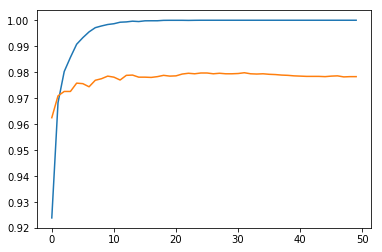

Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 0.0001
Learning rate decay: 0.0001
Epoch : 1 Loss : 0.930  Train Accuracy: 0.790 Validation Accuracy: 0.886
Epoch : 2 Loss : 0.405  Train Accuracy: 0.886 Validation Accuracy: 0.909
Epoch : 3 Loss : 0.330  Train Accuracy: 0.904 Validation Accuracy: 0.920
Epoch : 4 Loss : 0.297  Train Accuracy: 0.914 Validation Accuracy: 0.925
Epoch : 5 Loss : 0.273  Train Accuracy: 0.921 Validation Accuracy: 0.930
Epoch : 6 Loss : 0.256  Train Accuracy: 0.926 Validation Accuracy: 0.934
Epoch : 7 Loss : 0.241  Train Accuracy: 0.931 Validation Accuracy: 0.937
Epoch : 8 Loss : 0.229  Train Accuracy: 0.934 Validation Accuracy: 0.939
Epoch : 9 Loss : 0.219  Train Accuracy: 0.937 Validation Accuracy: 0.941
Epoch : 10 Loss : 0.210  Train Accuracy: 0.940 Validation Accuracy: 0.943
Epoch : 11 Loss : 0.203  Train Accuracy: 0.942 Validation Accuracy: 0.945
Epoch : 12 Loss : 0.196  Train Accuracy: 0.944 Validation Accuracy: 0.946
Epoch : 13 Loss : 0.19

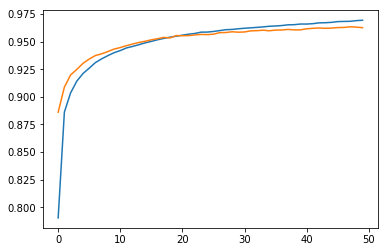

Neural Net Hyper params:
Layers: [784, 500, 250]
Learning Rate: 1e-05
Learning rate decay: 0.0001
Epoch : 1 Loss : 2.125  Train Accuracy: 0.273 Validation Accuracy: 0.431
Epoch : 2 Loss : 1.970  Train Accuracy: 0.504 Validation Accuracy: 0.595
Epoch : 3 Loss : 1.876  Train Accuracy: 0.609 Validation Accuracy: 0.667
Epoch : 4 Loss : 1.804  Train Accuracy: 0.662 Validation Accuracy: 0.704
Epoch : 5 Loss : 1.745  Train Accuracy: 0.690 Validation Accuracy: 0.729
Epoch : 6 Loss : 1.695  Train Accuracy: 0.709 Validation Accuracy: 0.744
Epoch : 7 Loss : 1.652  Train Accuracy: 0.723 Validation Accuracy: 0.755
Epoch : 8 Loss : 1.613  Train Accuracy: 0.734 Validation Accuracy: 0.764
Epoch : 9 Loss : 1.579  Train Accuracy: 0.743 Validation Accuracy: 0.772
Epoch : 10 Loss : 1.549  Train Accuracy: 0.750 Validation Accuracy: 0.777
Epoch : 11 Loss : 1.521  Train Accuracy: 0.755 Validation Accuracy: 0.783
Epoch : 12 Loss : 1.496  Train Accuracy: 0.760 Validation Accuracy: 0.788
Epoch : 13 Loss : 1.473

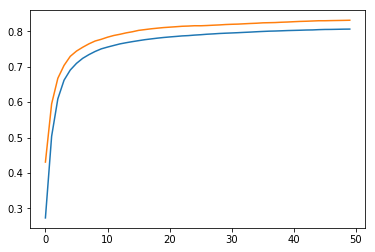

Neural Net Hyper params:
Layers: [784, 500, 500]
Learning Rate: 0.001
Learning rate decay: 0.0001
Epoch : 1 Loss : 0.242  Train Accuracy: 0.927 Validation Accuracy: 0.957
Epoch : 2 Loss : 0.093  Train Accuracy: 0.972 Validation Accuracy: 0.972
Epoch : 3 Loss : 0.052  Train Accuracy: 0.984 Validation Accuracy: 0.974
Epoch : 4 Loss : 0.034  Train Accuracy: 0.989 Validation Accuracy: 0.975
Epoch : 5 Loss : 0.023  Train Accuracy: 0.992 Validation Accuracy: 0.975
Epoch : 6 Loss : 0.015  Train Accuracy: 0.995 Validation Accuracy: 0.979
Epoch : 7 Loss : 0.011  Train Accuracy: 0.997 Validation Accuracy: 0.978
Epoch : 8 Loss : 0.007  Train Accuracy: 0.997 Validation Accuracy: 0.978
Epoch : 9 Loss : 0.004  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 10 Loss : 0.003  Train Accuracy: 0.999 Validation Accuracy: 0.979
Epoch : 11 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 12 Loss : 0.002  Train Accuracy: 1.000 Validation Accuracy: 0.979
Epoch : 13 Loss : 0.001

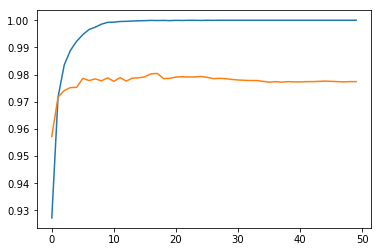

Neural Net Hyper params:
Layers: [784, 500, 500]
Learning Rate: 0.0001
Learning rate decay: 0.0001
Epoch : 1 Loss : 0.793  Train Accuracy: 0.818 Validation Accuracy: 0.896
Epoch : 2 Loss : 0.352  Train Accuracy: 0.898 Validation Accuracy: 0.915
Epoch : 3 Loss : 0.295  Train Accuracy: 0.914 Validation Accuracy: 0.927
Epoch : 4 Loss : 0.265  Train Accuracy: 0.924 Validation Accuracy: 0.932
Epoch : 5 Loss : 0.243  Train Accuracy: 0.930 Validation Accuracy: 0.936
Epoch : 6 Loss : 0.226  Train Accuracy: 0.935 Validation Accuracy: 0.941
Epoch : 7 Loss : 0.213  Train Accuracy: 0.939 Validation Accuracy: 0.942
Epoch : 8 Loss : 0.202  Train Accuracy: 0.942 Validation Accuracy: 0.945
Epoch : 9 Loss : 0.191  Train Accuracy: 0.945 Validation Accuracy: 0.947
Epoch : 10 Loss : 0.181  Train Accuracy: 0.948 Validation Accuracy: 0.951
Epoch : 11 Loss : 0.172  Train Accuracy: 0.951 Validation Accuracy: 0.953
Epoch : 12 Loss : 0.165  Train Accuracy: 0.952 Validation Accuracy: 0.954
Epoch : 13 Loss : 0.15

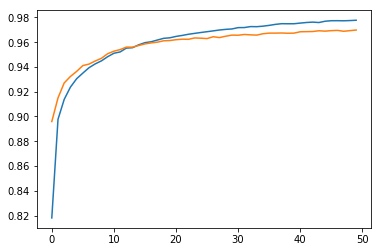

Neural Net Hyper params:
Layers: [784, 500, 500]
Learning Rate: 1e-05
Learning rate decay: 0.0001
Epoch : 1 Loss : 2.121  Train Accuracy: 0.360 Validation Accuracy: 0.544
Epoch : 2 Loss : 1.944  Train Accuracy: 0.589 Validation Accuracy: 0.663
Epoch : 3 Loss : 1.836  Train Accuracy: 0.663 Validation Accuracy: 0.708
Epoch : 4 Loss : 1.753  Train Accuracy: 0.697 Validation Accuracy: 0.734
Epoch : 5 Loss : 1.685  Train Accuracy: 0.719 Validation Accuracy: 0.752
Epoch : 6 Loss : 1.628  Train Accuracy: 0.734 Validation Accuracy: 0.764
Epoch : 7 Loss : 1.578  Train Accuracy: 0.745 Validation Accuracy: 0.774
Epoch : 8 Loss : 1.535  Train Accuracy: 0.753 Validation Accuracy: 0.781
Epoch : 9 Loss : 1.496  Train Accuracy: 0.759 Validation Accuracy: 0.788
Epoch : 10 Loss : 1.462  Train Accuracy: 0.764 Validation Accuracy: 0.792
Epoch : 11 Loss : 1.431  Train Accuracy: 0.769 Validation Accuracy: 0.796
Epoch : 12 Loss : 1.403  Train Accuracy: 0.773 Validation Accuracy: 0.800
Epoch : 13 Loss : 1.377

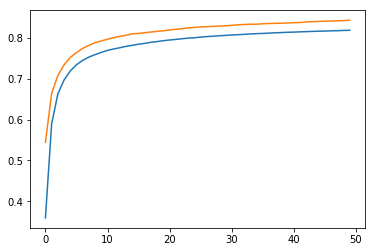

Neural Net Hyper params:
Layers: [784, 650, 650]
Learning Rate: 0.001
Learning rate decay: 0.0001
Epoch : 1 Loss : 0.227  Train Accuracy: 0.932 Validation Accuracy: 0.963
Epoch : 2 Loss : 0.085  Train Accuracy: 0.974 Validation Accuracy: 0.971
Epoch : 3 Loss : 0.052  Train Accuracy: 0.984 Validation Accuracy: 0.975
Epoch : 4 Loss : 0.032  Train Accuracy: 0.990 Validation Accuracy: 0.978
Epoch : 5 Loss : 0.021  Train Accuracy: 0.993 Validation Accuracy: 0.976
Epoch : 6 Loss : 0.015  Train Accuracy: 0.995 Validation Accuracy: 0.978
Epoch : 7 Loss : 0.010  Train Accuracy: 0.997 Validation Accuracy: 0.978
Epoch : 8 Loss : 0.007  Train Accuracy: 0.997 Validation Accuracy: 0.978
Epoch : 9 Loss : 0.005  Train Accuracy: 0.998 Validation Accuracy: 0.978
Epoch : 10 Loss : 0.003  Train Accuracy: 0.999 Validation Accuracy: 0.979
Epoch : 11 Loss : 0.003  Train Accuracy: 0.999 Validation Accuracy: 0.980
Epoch : 12 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 13 Loss : 0.002

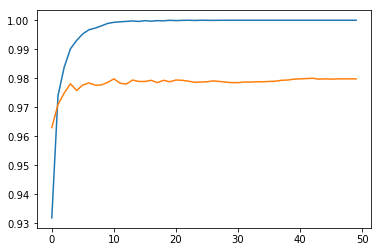

Neural Net Hyper params:
Layers: [784, 650, 650]
Learning Rate: 0.0001
Learning rate decay: 0.0001
Epoch : 1 Loss : 0.672  Train Accuracy: 0.843 Validation Accuracy: 0.909
Epoch : 2 Loss : 0.313  Train Accuracy: 0.909 Validation Accuracy: 0.927
Epoch : 3 Loss : 0.270  Train Accuracy: 0.923 Validation Accuracy: 0.934
Epoch : 4 Loss : 0.239  Train Accuracy: 0.933 Validation Accuracy: 0.939
Epoch : 5 Loss : 0.216  Train Accuracy: 0.940 Validation Accuracy: 0.944
Epoch : 6 Loss : 0.201  Train Accuracy: 0.943 Validation Accuracy: 0.946
Epoch : 7 Loss : 0.187  Train Accuracy: 0.946 Validation Accuracy: 0.949
Epoch : 8 Loss : 0.172  Train Accuracy: 0.951 Validation Accuracy: 0.954
Epoch : 9 Loss : 0.160  Train Accuracy: 0.954 Validation Accuracy: 0.954
Epoch : 10 Loss : 0.149  Train Accuracy: 0.957 Validation Accuracy: 0.958
Epoch : 11 Loss : 0.142  Train Accuracy: 0.959 Validation Accuracy: 0.957
Epoch : 12 Loss : 0.135  Train Accuracy: 0.962 Validation Accuracy: 0.960
Epoch : 13 Loss : 0.12

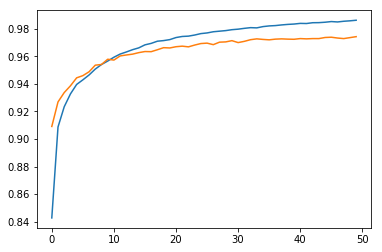

Neural Net Hyper params:
Layers: [784, 650, 650]
Learning Rate: 1e-05
Learning rate decay: 0.0001
Epoch : 1 Loss : 2.074  Train Accuracy: 0.443 Validation Accuracy: 0.651
Epoch : 2 Loss : 1.863  Train Accuracy: 0.673 Validation Accuracy: 0.729
Epoch : 3 Loss : 1.734  Train Accuracy: 0.719 Validation Accuracy: 0.759
Epoch : 4 Loss : 1.636  Train Accuracy: 0.741 Validation Accuracy: 0.773
Epoch : 5 Loss : 1.555  Train Accuracy: 0.756 Validation Accuracy: 0.786
Epoch : 6 Loss : 1.487  Train Accuracy: 0.767 Validation Accuracy: 0.795
Epoch : 7 Loss : 1.429  Train Accuracy: 0.775 Validation Accuracy: 0.801
Epoch : 8 Loss : 1.378  Train Accuracy: 0.782 Validation Accuracy: 0.806
Epoch : 9 Loss : 1.334  Train Accuracy: 0.786 Validation Accuracy: 0.811
Epoch : 10 Loss : 1.294  Train Accuracy: 0.791 Validation Accuracy: 0.815
Epoch : 11 Loss : 1.259  Train Accuracy: 0.794 Validation Accuracy: 0.818
Epoch : 12 Loss : 1.227  Train Accuracy: 0.797 Validation Accuracy: 0.820
Epoch : 13 Loss : 1.198

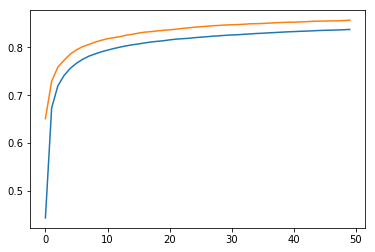

In [152]:
#Hyper parameter search

hparams = {
    "layers": [[28*28,500,250], [28*28,500,500],[28*28,650,650]],
    "lr": [1e-3,1e-4,1e-5],
    "lr_decay": [10e-5]
}

bestModel, bestValAcc = hyperparamsearch(50, hparams, mnist_train, mnist_val,verbose=False)
                

In [153]:
print bestModel
print bestValAcc

MLP_MNIST(
  (fc1): Linear(in_features=784, out_features=500)
  (dropout1): Dropout(p=0.0)
  (fc2): Linear(in_features=500, out_features=500)
  (dropout2): Dropout(p=0.0)
  (fc3): Linear(in_features=500, out_features=10)
)
0.9804


### 1.B.2.2
The best model was had the following hyperparameters:
Hidden layers of size 500 units each, a batch size of 64, Rectified Linear units as nonlinearities.
Additionally the optimizer is an Adagrad optimizer with a learning rate 0.001 and a decay rate of 0.0001


## 1.B.3 Training the best model for 100 Epochs

The model is identical to that listed above, but is now trained twice as long.

In [154]:
#Training the best model for 100 epochs
layers = [784, 500, 500]
lr = 0.001
lr_decay=0.0001
model = MLP_MNIST(layers,10)
model = GlorotInitialize(model)
optimizer = torch.optim.Adagrad(model.parameters(), lr=lr,lr_decay = lr_decay)
train_results = train(model,100,mnist_train,optimizer,mnist_val)

Epoch : 1 Loss : 0.253  Train Accuracy: 0.925 Validation Accuracy: 0.959
Epoch : 2 Loss : 0.095  Train Accuracy: 0.971 Validation Accuracy: 0.971
Epoch : 3 Loss : 0.055  Train Accuracy: 0.982 Validation Accuracy: 0.972
Epoch : 4 Loss : 0.035  Train Accuracy: 0.989 Validation Accuracy: 0.976
Epoch : 5 Loss : 0.022  Train Accuracy: 0.993 Validation Accuracy: 0.977
Epoch : 6 Loss : 0.015  Train Accuracy: 0.995 Validation Accuracy: 0.979
Epoch : 7 Loss : 0.010  Train Accuracy: 0.997 Validation Accuracy: 0.978
Epoch : 8 Loss : 0.006  Train Accuracy: 0.998 Validation Accuracy: 0.978
Epoch : 9 Loss : 0.005  Train Accuracy: 0.998 Validation Accuracy: 0.978
Epoch : 10 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 11 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 12 Loss : 0.002  Train Accuracy: 1.000 Validation Accuracy: 0.979
Epoch : 13 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.979
Epoch : 14 Loss : 0.001  Train Accuracy: 1.000 

MLP_MNIST(
  (fc1): Linear(in_features=784, out_features=500)
  (dropout1): Dropout(p=0.0)
  (fc2): Linear(in_features=500, out_features=500)
  (dropout2): Dropout(p=0.0)
  (fc3): Linear(in_features=500, out_features=10)
)


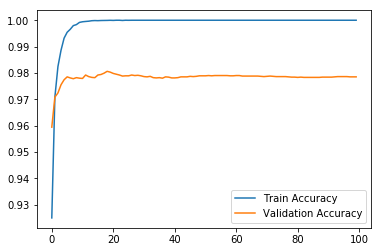

In [155]:
(bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy) = train_results

print bestNetwork

plt.plot(train_accuracy, label = 'Train Accuracy')
plt.plot(val_accuracy, label= 'Validation Accuracy')
plt.legend()
plt.show()

## 1.B.4 Doubling the number of parameters

In [159]:
print 'Best validation accuracy: ' + repr(bestValAcc)
print 'Best model: ' + repr(bestModel)
params = list(bestModel.parameters())
sum_params=0
for p in params:
    print p.size()
    if len(p.size()) > 1:
        sum_params += p.size()[0]*p.size()[1]
    else:
        sum_params += p.size()[0]
print ('Total number of parameters in best model: %d' %sum_params)
print 2*sum_params

Best validation accuracy: 0.9804
Best model: MLP_MNIST(
  (fc1): Linear(in_features=784, out_features=500)
  (dropout1): Dropout(p=0.0)
  (fc2): Linear(in_features=500, out_features=500)
  (dropout2): Dropout(p=0.0)
  (fc3): Linear(in_features=500, out_features=10)
)
torch.Size([500, 784])
torch.Size([500])
torch.Size([500, 500])
torch.Size([500])
torch.Size([10, 500])
torch.Size([10])
Total number of parameters in best model: 648010
1296020


Currently there are: (784+(784*500) + 800+(800*450)+ (450*10)+450+ 10) = 992,960 parameters


(in_size+(in_size*size1) + size1 + (size1*size2) + size2 + (size2*outsize) + outsize

We would like to create a new model with twice as many parameters, 1,985,920 parameters.



In [165]:
layerDims = [784,1005,500]
lr=0.001
lr_decay = 0.0001
Double_NN = MLP_MNIST(layerDims,10)
params = list(Double_NN.parameters())
sum_params=0
for p in params:
    print p.size()
    if len(p.size()) > 1:
        sum_params += p.size()[0]*p.size()[1]
    else:
        sum_params += p.size()[0]
        
print ('Total number of parameters in double size model: %d' %sum_params)

torch.Size([1005, 784])
torch.Size([1005])
torch.Size([500, 1005])
torch.Size([500])
torch.Size([10, 500])
torch.Size([10])
Total number of parameters in double size model: 1296935


In [166]:
Double_NN = GlorotInitialize(Double_NN)
optimizer = torch.optim.Adagrad(Double_NN.parameters(), lr=lr,lr_decay=lr_decay)
(Double_NN, epoch_loss, double_train_accuracy, double_val_accuracy, double_test_acc) = train(Double_NN,100,mnist_train,optimizer,mnist_val)


Epoch : 1 Loss : 0.219  Train Accuracy: 0.934 Validation Accuracy: 0.967
Epoch : 2 Loss : 0.081  Train Accuracy: 0.975 Validation Accuracy: 0.975
Epoch : 3 Loss : 0.048  Train Accuracy: 0.985 Validation Accuracy: 0.974
Epoch : 4 Loss : 0.027  Train Accuracy: 0.991 Validation Accuracy: 0.976
Epoch : 5 Loss : 0.017  Train Accuracy: 0.994 Validation Accuracy: 0.977
Epoch : 6 Loss : 0.011  Train Accuracy: 0.996 Validation Accuracy: 0.979
Epoch : 7 Loss : 0.007  Train Accuracy: 0.997 Validation Accuracy: 0.980
Epoch : 8 Loss : 0.003  Train Accuracy: 0.999 Validation Accuracy: 0.979
Epoch : 9 Loss : 0.003  Train Accuracy: 0.999 Validation Accuracy: 0.978
Epoch : 10 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.980
Epoch : 11 Loss : 0.002  Train Accuracy: 0.999 Validation Accuracy: 0.980
Epoch : 12 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.978
Epoch : 13 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.978
Epoch : 14 Loss : 0.000  Train Accuracy: 1.000 

In [167]:
print max(double_val_accuracy)

0.98


## 1.B.5 Why does a network with double the size perform worse on the validation set?

We see that while close, the smaller network performs better than the larger network by .04%.  This can be attributed to the increased capacity of the model.
Here we have not increased regularization within the network, in fact both networks have no regularization at all.  By doubling the capacity of the model, we have also increased the inherent variance found within the trained model. It is now more prone to overfitting than a smaller model.  While the error from bias may have been reduced, the model now has an increased error from variance. The increase in variance error, is larger than the decrease of bias error. This is known as the bias-variance tradeoff.

# Training Set Size, Generalization Gap, and Standard Error

First we'll randomly sample subsets of the training data. For each subsample we will train a model with the following hyperparameters:

Batch size = 64
Model architecture: 2 hidden layers, each with 500 neurons.
Non-linearities: Rectivfied Linear Units
Learning Rate: 0.001
Learning rate decay: 0.0001


In [20]:
alphas = [0.01,0.02,0.05,0.1,1.0]
TRAINSIZE = mnist_train_data.shape[0]
indices = list(range(TRAINSIZE))

#Hyperparameters for model
layerDims = [784,500,500]
lr=0.001
lr_decay = .0001
batch_size=64
repeat_test_results = [{}]*5
generalization_gap = [0]*5
for alpha in alphas:
    print "Alpha: " +repr(alpha)
    for i in range(0,5):  
        print "Test number: " + repr(i+1)
        subindices = np.random.choice(indices,size=[int(alpha*TRAINSIZE)])
        train_data_subset = mnist_train_data[subindices,:]
        train_labels_subset = mnist_train_labels[subindices]
        train_data_tensor = torch.utils.data.TensorDataset(torch.Tensor(train_data_subset),torch.IntTensor(train_labels_subset))

        subtrainloader = torch.utils.data.DataLoader(train_data_tensor, batch_size=batch_size, shuffle=True, num_workers=2)
        model = MLP_MNIST(layerDims,10)
        optimizer = torch.optim.Adagrad(model.parameters(),lr=lr, lr_decay=lr_decay)
        test_results = train(model,100,subtrainloader,optimizer,mnist_val,mnist_test,verbose=True)
        bestNetwork, epoch_loss, train_accuracy, val_accuracy, test_accuracy = test_results
        best_epoch = int(np.argmax(val_accuracy))
        generalization_gap[i] = train_accuracy[best_epoch] - test_accuracy[best_epoch]
        print "Generalization gap for test: " + repr(generalization_gap[i])
    print ("Average generalization gap for alpha:  %.2f:  %.4f" %(alpha, np.mean(generalization_gap)))

Alpha: 0.01
Test number: 1
Epoch : 1 Loss : 2.205  Train Accuracy: 0.318 Validation Accuracy: 0.397 Test Accuracy: 0.400
Epoch : 21 Loss : 0.019  Train Accuracy: 0.998 Validation Accuracy: 0.867 Test Accuracy: 0.861
Epoch : 41 Loss : 0.001  Train Accuracy: 1.000 Validation Accuracy: 0.859 Test Accuracy: 0.857
Epoch : 61 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.865 Test Accuracy: 0.863
Epoch : 81 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.864 Test Accuracy: 0.860
Generalization gap for test: 0.12190000000000001
Test number: 2
Epoch : 1 Loss : 2.185  Train Accuracy: 0.318 Validation Accuracy: 0.522 Test Accuracy: 0.522
Epoch : 21 Loss : 0.014  Train Accuracy: 1.000 Validation Accuracy: 0.855 Test Accuracy: 0.854
Epoch : 41 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.840 Test Accuracy: 0.840
Epoch : 61 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.839 Test Accuracy: 0.838
Epoch : 81 Loss : 0.000  Train Accuracy: 1.000 Validatio

Epoch : 1 Loss : 0.997  Train Accuracy: 0.744 Validation Accuracy: 0.853 Test Accuracy: 0.846
Epoch : 21 Loss : 0.005  Train Accuracy: 0.999 Validation Accuracy: 0.939 Test Accuracy: 0.937
Epoch : 41 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.940 Test Accuracy: 0.938
Epoch : 61 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.940 Test Accuracy: 0.936
Epoch : 81 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.939 Test Accuracy: 0.934
Generalization gap for test: 0.060799999999999965
Test number: 2
Epoch : 1 Loss : 0.993  Train Accuracy: 0.725 Validation Accuracy: 0.880 Test Accuracy: 0.871
Epoch : 21 Loss : 0.010  Train Accuracy: 0.997 Validation Accuracy: 0.938 Test Accuracy: 0.937
Epoch : 41 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.944 Test Accuracy: 0.941
Epoch : 61 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.943 Test Accuracy: 0.939
Epoch : 81 Loss : 0.000  Train Accuracy: 1.000 Validation Accuracy: 0.942 Test Acc

### 1.C.3 Results of Generalization Gap Experiment

| Alpha  | Result 1 | Result 2 |  Result 3 |  Result 4 |  Result 5 | Average | Standard Error |
|--------|----------|----------|-----------|-----------|-----------|---------|----------------|
|  0.01  |   12.2%  |   10.8%  |  10.1%    |   9.00%   |   13.7%   |  11.17% |    0.0164      |
|  0.02  |   9.30%  |   7.5%   |  7.8%     |   5.6%    |   12.2%   |  8.48%  |    0.0220      |
|  0.05  |   8.6%   |   8.2%   |  8.7%     |  8.6%     |   8.2%    |  8.43%  |    0.0022      |
|  0.1   |   6.0%   |   5.9%   |  6.3%     |  6.3%     |  6.3%     |  6.16%  |    0.0017      |
|  1.0   |   2.6%   |   3.00%  |  2.61%    |  2.7%     |  2.8%     |  2.75%  |    0.0015      |

### 1.C.4 Comments about results

First, it should be noted that the average of the generalization gap decreases as more of the dataset is used to train the model.  This follows from the ability of a model to generalize better as data is increased.  Additionally, on small amounts of data, the model is very likely to overfit and therefore generalize worse overall, when compared to using larger amounts of data.

Also, it can be seen that generally the standard error of the Generalization gap decreases. This is because more data acts as a regularizer, thus decreasing the variance of the model overall. As such, the model is more likely to generalize similarily well when more data is used to train it. 